# Cultural Parameter Optimization - Warlike

### **3T-8L1R: 3 Teams composed of 8 agents (3, 2, 3) and 1 Random Agent**

Teams with Warlike culture require much longer training episodes, so we have a separate notebook specifically for training them.

In [6]:
import os
import random
import time
import pickle
import platform
import torch
import gym
import numpy as np

# This is the Gathering Game Environment based on Tribal Organization of agents
from tribes_env import GatheringEnv
from tribes_model import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


## Culture = Warlike

Run finish_episode() specific to this culture.

In [2]:
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    total_norms = [0 for i in range(num_learners)]
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    T_reward = []

   
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        for t in tribes:
            if t.name is learners[i].tribe:
                T_reward = t.tribal_awards(US_hits = learners[i].US_hits,THEM_hits = learners[i].THEM_hits)
 
                # For debug only
                # print('Agent{} receives tribal award from Tribe{}'.format(i,t.name))
                # print (T_reward)
                # print (learners[i].rewards)
                
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r,T in zip(learners[i].rewards[::-1],T_reward[::-1]):
            # The agent is incentivized to cooperate by an award of 30% of what the tribe takes
            # in by all its members
            R = r + T + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norms[i] = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        learners[i].clear_history()   # clear an agent's history at the end of episode


    return total_norms

## Special Case - Warlike Culture

We discovered that if we run training of only 300 game steps, the agents with Warlike culture will spend the 1st hundreds of steps in mutually assured destruction - a field of deadly crossfire which they cannot escape out of.

So we lengthen the game step to 1000 instead.

In [12]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   9 agents - 8 learning agents, 0 trained agents, 1 random agents
num_learners = 8
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
num_actions = 8                       # 8 actions in Gathering

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 2000
max_frames = 1000
max_frames_ep = 0   # track highest number of frames an episode can last

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 100
save_interval = 500


def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""


def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 


def load_info(agents, narrate=False):
    for i in range(num_agents):    
        agents[i].load_info(info[i])
        if narrate:
            if agents[i].tagged:
                print('frame {}, agent{} is tagged'.format(frame,i))
            if agents[i].laser_fired:
                print('frame {}, agent{} fires its laser'.format(frame,i))
                print('and hit {} US and {} THEM'.format(agents[i].US_hit, agents[i].THEM_hit))
    return


# The main code starts here!!!

cultures =[{'name':'warlike', 'penalty':-1.0, 'reward':0.001}
          ]
# Cultural parameter search
"""
cultures =[{'name':'warlike', 'penalty':-1.0, 'reward':0.001},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.005},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.01},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.05},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.1},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.5},
           {'name':'warlike', 'penalty':-1.0, 'reward':1.0}
          ]
"""


for culture in cultures:   # Go down the list of cultures

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("No trained agent exist yet!")
            raise
            """
            Disable for now! No trained model exist!!!
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association
    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
    tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4]]))
    tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[5], agents[6], agents[7]]))
    tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[8]]))   # random agents are crazy!!!

    # 9 agents in 4 tribes, used map defined in default.txt
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                       map_name='default')    
   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break
            
        if frame > max_frames_ep:
            max_frames_ep = frame    # Keep track of highest frames/episode

        # Update reward statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])

        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'MA_models/3T-8L1R/'
                results_dir = 'results/3T-8L1R/'

                model_file = model_dir+'{}-01/p{}_r{}/MA{}_{}__ep{}.p'.format(culture['name'], culture['penalty'],\
                                 culture['reward'], i, game, ep+prior_eps+1)
                data_file = results_dir+'{}-01/p{}_r{}/MA{}_{}.p'.format(culture['name'], culture['penalty'],\
                                                      culture['reward'], i, game)
                
                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Load random agent 8
....................................................................................................
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.01182
Learner:1	Reward total:0	Running mean: 0.5735
Learner:2	Reward total:0	Running mean: 1.202
Learner:3	Reward total:0	Running mean: 0.1754
Learner:4	Reward total:0	Running mean: 0.814
Learner:5	Reward total:0	Running mean: 0.3248
Learner:6	Reward total:5	Running mean: 1.968
Learner:7	Reward total:18	Running mean: 3.002
Max Norms =  ['0.00', '204.16', '196.74', '238.06', '148.19', '344.12', '171.93', '245.45']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:0	Running mean: 0.02019
Learner:1	Reward total:3	Running mean: 5.62
Learner:2	Reward total:53	Running mean: 13.31
Learner:3	Rew

Max Norms =  ['69.62', '261.99', '188.03', '197.58', '165.59', '103.44', '263.83', '233.48']
....................................................................................................
Episode 1500 complete
Learner:0	Reward total:24	Running mean: 33.83
Learner:1	Reward total:36	Running mean: 34.87
Learner:2	Reward total:112	Running mean: 95.11
Learner:3	Reward total:27	Running mean: 27.94
Learner:4	Reward total:78	Running mean: 104.7
Learner:5	Reward total:34	Running mean: 25.53
Learner:6	Reward total:63	Running mean: 74.26
Learner:7	Reward total:11	Running mean: 30.04
Max Norms =  ['50.43', '147.55', '189.69', '120.19', '183.53', '155.30', '283.57', '327.35']
....................................................................................................
Episode 1600 complete
Learner:0	Reward total:52	Running mean: 37.74
Learner:1	Reward total:34	Running mean: 38.25
Learner:2	Reward total:108	Running mean: 99.45
Learner:3	Reward total:34	Running mean: 29.21
Learner:4	Rewa

Load AI agent 0
Load AI agent 1
Load AI agent 2
Load AI agent 3
Load AI agent 4
Load AI agent 5
Load AI agent 6
Load AI agent 7
Load AI agent 8
results/3T-8L1R/warlike-01/p-1.0_r0.0001/
Max. Running Reward - MA0 Ind Reward: 35.482
Max. Running Reward - MA1 Ind Reward: 33.351
Max. Running Reward - MA2 Ind Reward: 38.254
Max. Running Reward - MA3 Ind Reward: 85.363
Max. Running Reward - MA4 Ind Reward: 57.432
Max. Running Reward - MA5 Ind Reward: 115.764
Max. Running Reward - MA6 Ind Reward: 82.850
Max. Running Reward - MA7 Ind Reward: 126.202
Max. Running Reward - All Agents: 434.478
Tribe 0 Sum Reward: 100.506
Tribe 1 Sum Reward: 113.277
Tribe 2 Sum Reward: 276.299




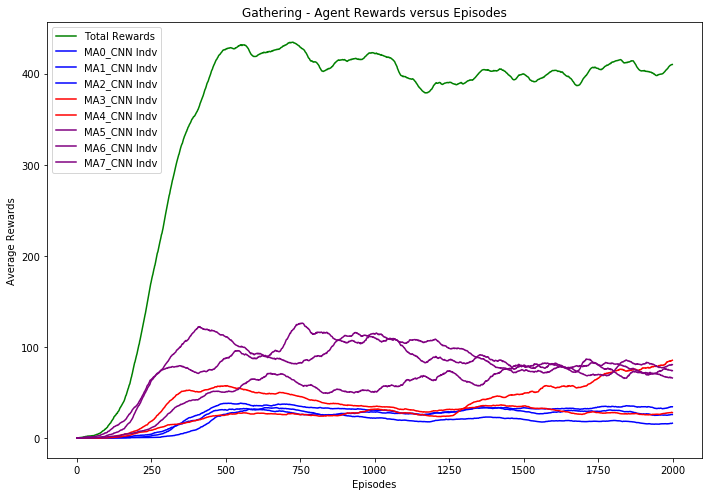

results/3T-8L1R/warlike-01/p-1.0_r0.001/
Max. Running Reward - MA0 Ind Reward: 38.764
Max. Running Reward - MA1 Ind Reward: 45.551
Max. Running Reward - MA2 Ind Reward: 146.132
Max. Running Reward - MA3 Ind Reward: 31.540
Max. Running Reward - MA4 Ind Reward: 157.491
Max. Running Reward - MA5 Ind Reward: 30.834
Max. Running Reward - MA6 Ind Reward: 81.652
Max. Running Reward - MA7 Ind Reward: 82.682
Max. Running Reward - All Agents: 465.621
Tribe 0 Sum Reward: 200.422
Tribe 1 Sum Reward: 182.079
Tribe 2 Sum Reward: 194.278




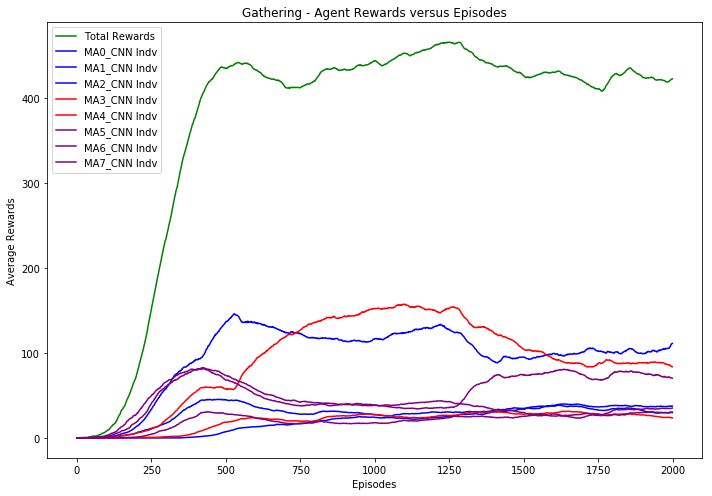

results/3T-8L1R/warlike-01/p-1.0_r0.005/
Max. Running Reward - MA0 Ind Reward: 31.162
Max. Running Reward - MA1 Ind Reward: 35.094
Max. Running Reward - MA2 Ind Reward: 65.069
Max. Running Reward - MA3 Ind Reward: 93.815
Max. Running Reward - MA4 Ind Reward: 70.756
Max. Running Reward - MA5 Ind Reward: 19.765
Max. Running Reward - MA6 Ind Reward: 186.372
Max. Running Reward - MA7 Ind Reward: 144.059
Max. Running Reward - All Agents: 453.455
Tribe 0 Sum Reward: 95.962
Tribe 1 Sum Reward: 148.749
Tribe 2 Sum Reward: 282.035




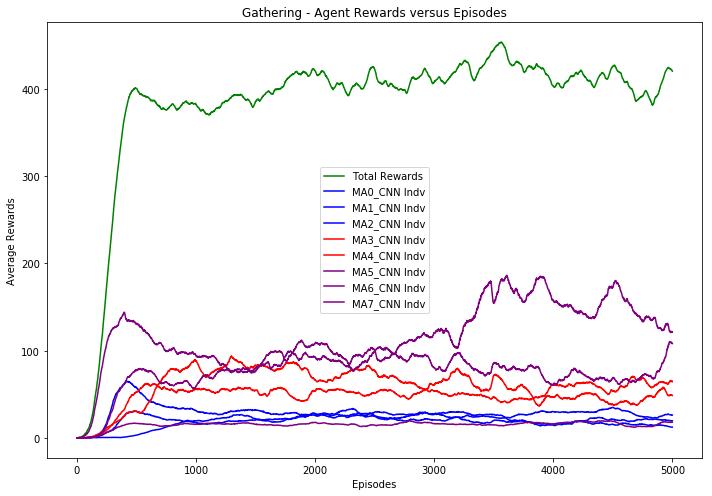

results/3T-8L1R/warlike-01/p-1.0_r0.01/
Max. Running Reward - MA0 Ind Reward: 55.410
Max. Running Reward - MA1 Ind Reward: 35.292
Max. Running Reward - MA2 Ind Reward: 139.510
Max. Running Reward - MA3 Ind Reward: 51.132
Max. Running Reward - MA4 Ind Reward: 110.948
Max. Running Reward - MA5 Ind Reward: 54.967
Max. Running Reward - MA6 Ind Reward: 69.850
Max. Running Reward - MA7 Ind Reward: 101.841
Max. Running Reward - All Agents: 437.258
Tribe 0 Sum Reward: 207.455
Tribe 1 Sum Reward: 129.565
Tribe 2 Sum Reward: 211.144




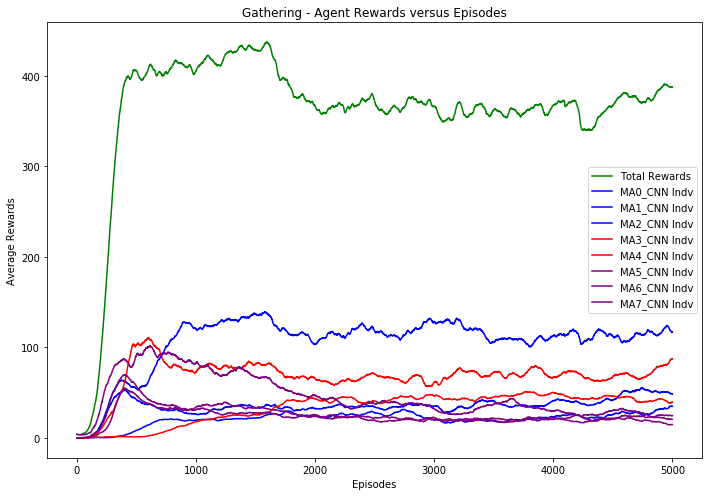

results/3T-8L1R/warlike-01/p-1.0_r0.05/
Max. Running Reward - MA0 Ind Reward: 28.275
Max. Running Reward - MA1 Ind Reward: 156.951
Max. Running Reward - MA2 Ind Reward: 41.035
Max. Running Reward - MA3 Ind Reward: 65.411
Max. Running Reward - MA4 Ind Reward: 116.753
Max. Running Reward - MA5 Ind Reward: 72.127
Max. Running Reward - MA6 Ind Reward: 79.112
Max. Running Reward - MA7 Ind Reward: 38.658
Max. Running Reward - All Agents: 422.706
Tribe 0 Sum Reward: 196.254
Tribe 1 Sum Reward: 164.541
Tribe 2 Sum Reward: 155.462




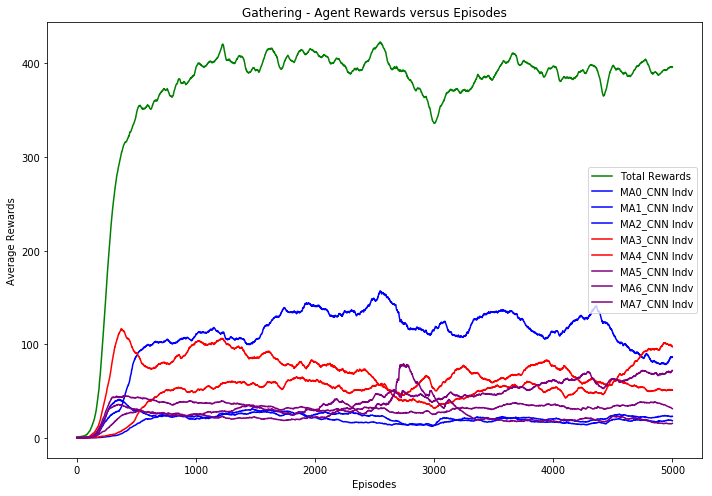

results/3T-8L1R/warlike/p-1.0_r0.1/
Max. Running Reward - MA0 Ind Reward: 40.015
Max. Running Reward - MA1 Ind Reward: 31.009
Max. Running Reward - MA2 Ind Reward: 91.506
Max. Running Reward - MA3 Ind Reward: 27.012
Max. Running Reward - MA4 Ind Reward: 101.251
Max. Running Reward - MA5 Ind Reward: 65.966
Max. Running Reward - MA6 Ind Reward: 27.843
Max. Running Reward - MA7 Ind Reward: 87.807
Max. Running Reward - All Agents: 374.727
Tribe 0 Sum Reward: 154.699
Tribe 1 Sum Reward: 107.617
Tribe 2 Sum Reward: 163.123




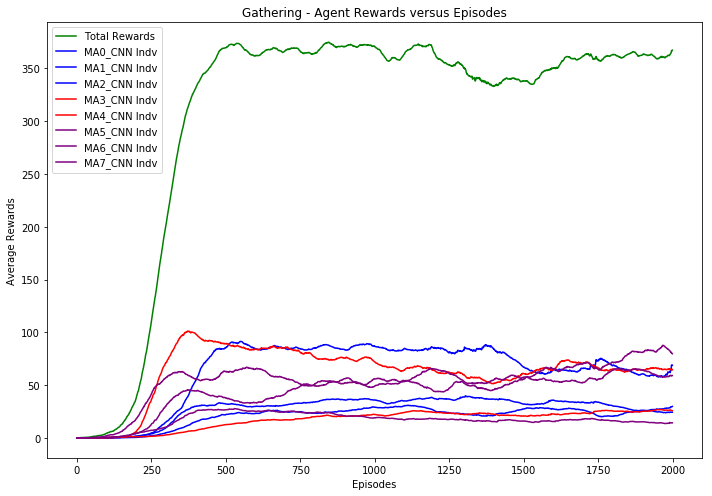

results/3T-8L1R/warlike/p-1.0_r0.5/
Max. Running Reward - MA0 Ind Reward: 0.391
Max. Running Reward - MA1 Ind Reward: 0.000
Max. Running Reward - MA2 Ind Reward: 0.000
Max. Running Reward - MA3 Ind Reward: 0.060
Max. Running Reward - MA4 Ind Reward: 0.050
Max. Running Reward - MA5 Ind Reward: 0.194
Max. Running Reward - MA6 Ind Reward: 0.110
Max. Running Reward - MA7 Ind Reward: 4.220
Max. Running Reward - All Agents: 4.737
Tribe 0 Sum Reward: 0.391
Tribe 1 Sum Reward: 0.081
Tribe 2 Sum Reward: 4.335




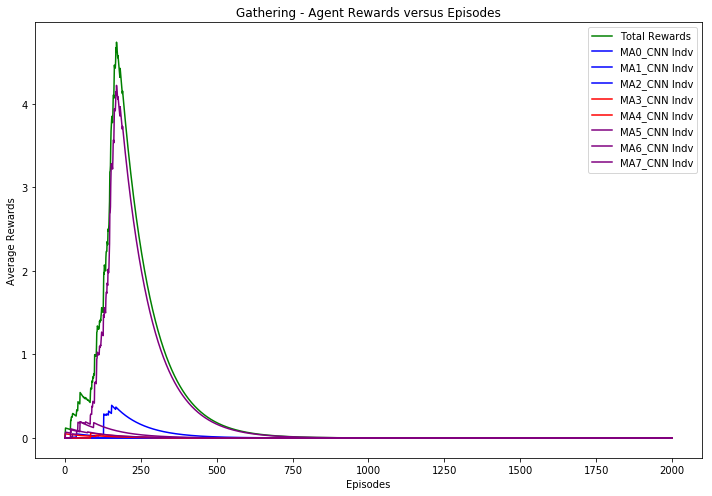

results/3T-8L1R/warlike/p-1.0_r1.0/
Max. Running Reward - MA0 Ind Reward: 0.010
Max. Running Reward - MA1 Ind Reward: 0.000
Max. Running Reward - MA2 Ind Reward: 0.000
Max. Running Reward - MA3 Ind Reward: 0.000
Max. Running Reward - MA4 Ind Reward: 0.010
Max. Running Reward - MA5 Ind Reward: 0.101
Max. Running Reward - MA6 Ind Reward: 0.136
Max. Running Reward - MA7 Ind Reward: 0.326
Max. Running Reward - All Agents: 0.525
Tribe 0 Sum Reward: 0.010
Tribe 1 Sum Reward: 0.010
Tribe 2 Sum Reward: 0.519




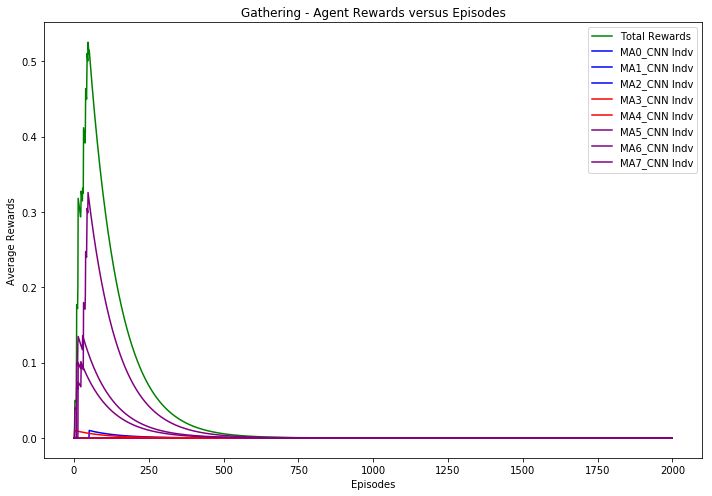

In [8]:
game = 'Gathering'

dir_names = ["results/3T-8L1R/warlike-01/p-1.0_r0.0001/",
             "results/3T-8L1R/warlike-01/p-1.0_r0.001/",
             "results/3T-8L1R/warlike-01/p-1.0_r0.005/",  # trained to 5000 episodes
             "results/3T-8L1R/warlike-01/p-1.0_r0.01/",   # trained to 5000 episodes
             "results/3T-8L1R/warlike-01/p-1.0_r0.05/",   # trained to 5000 episodes
             "results/3T-8L1R/warlike/p-1.0_r0.1/",
             "results/3T-8L1R/warlike/p-1.0_r0.5/",
             "results/3T-8L1R/warlike/p-1.0_r1.0/"]

num_learners = 8
num_tribes = 3

# Cultural parameter search
culture = 'warlike'

agents = []
for i in range(9):
    print("Load AI agent {}".format(i))
    agents.append(Policy(4, 8, i))

# Establish tribal association
tribes = []
tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4]]))
tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[5], agents[6], agents[7]]))
tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[8]]))   # random agents are crazy!!!

# 9 agents in 4 tribes
agent_colors = [agent.color for agent in agents]
agent_tribes = [agent.tribe for agent in agents]


for dir_name in dir_names:
    print (dir_name)
    data = [[] for i in range(num_learners)]
    tribe_data = [[] for i in range(num_tribes)]

    # Load rewards
    for i in range(num_learners):
        data_file = dir_name+'MA{}_Gather.p'.format(i, game)
        with open(data_file, 'rb') as f:
            data[i] = pickle.load(f)

    total = [sum(x) for x in zip(*data)]

    for i in range(num_learners):
        print('Max. Running Reward - MA{} Ind Reward: {:.3f}'.format(i, max(data[i])))

    
    print('Max. Running Reward - All Agents: {:.3f}'.format(max(total)))

    tribe_data[0] = [sum(x) for x in zip(data[0],data[1],data[2])]
    tribe_data[1] = [sum(x) for x in zip(data[3],data[4])]
    tribe_data[2] = [sum(x) for x in zip(data[5],data[6],data[7])]

    for i in range(num_tribes):
        print('Tribe {} Sum Reward: {:.3f}'.format(i, max(tribe_data[i])))
    
    print ('\n')

    plt.figure(figsize=(10, 7))
    plt.plot(total, label='Total Rewards', color='green')
    for i in range(num_learners):
        plt.plot(data[i], label='MA{}_CNN Indv'.format(i), color=agent_colors[i])

    plt.title('{} - Agent Rewards versus Episodes'.format(game))
    plt.xlabel('Episodes')
    plt.ylabel('Average Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()